In [1]:
import torch
import numpy as np

from models.cnp import CNP

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
# device = torch.device("cpu")

In [2]:
x = torch.from_numpy(np.load('/home/yigit/projects/mbcnp/data/raw/dataverse_files/Sines_full/constrained_torques.npy'))[:50]
y = torch.from_numpy(np.load('/home/yigit/projects/mbcnp/data/raw/dataverse_files/Sines_full/measured_angles.npy'))[:50]
print(x.shape, y.shape)


torch.Size([50, 15000, 3]) torch.Size([50, 15000, 3])


In [3]:
batch_size = 16

model = CNP(3, 512, 3, 500, 500, 4, batch_size).to(device)
optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

In [4]:
def get_batch(x, y, traj_ids):
    dx, dy = x.shape[-1], y.shape[-1]
    n = x.shape[1]
    n_t = torch.randint(1, model.n_max_tar, (1,)).item()
    n_o = torch.randint(1, model.n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, dx+dy).to(device)
    tar = torch.zeros(batch_size, n_t, dx).to(device)
    tar_val = torch.zeros(batch_size, n_t, dy).to(device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(n)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        # print(x.shape, traj_ids[i], o_ids, t_ids)

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    return obs, tar, tar_val

In [5]:
epochs = 500000
epoch_iter = 3
min_loss = 1000000
avg_loss = 0

for epoch in range(epochs):
    epoch_loss = 0

    traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

    for i in range(epoch_iter):
        optimizer.zero_grad()
        obs, tar_x, tar_y = get_batch(x, y, traj_ids[i])
        pred, encoded_rep = model(obs, tar_x)
        loss = model.loss(pred, tar_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if epoch_loss < min_loss and epoch > 5e4:
        min_loss = epoch_loss
        torch.save(model.state_dict(), f'best_test_on_rrd.pt')

    avg_loss += epoch_loss

    if epoch % 100 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, avg_loss/100))
        avg_loss = 0

Epoch: 0, Loss: 0.08217808246612548
Epoch: 100, Loss: 1.069576650224626
Epoch: 200, Loss: 0.29840062974952164
Epoch: 300, Loss: -0.12839881521547794
Epoch: 400, Loss: -0.4172472564131022
Epoch: 500, Loss: -0.45674127630889416
Epoch: 600, Loss: -0.47610307971946897
Epoch: 700, Loss: -0.49313811466097834
Epoch: 800, Loss: -0.5053311376273633
Epoch: 900, Loss: -0.5030578497797251
Epoch: 1000, Loss: -0.5220067962259054
Epoch: 1100, Loss: -0.5276817967742682
Epoch: 1200, Loss: -0.5401852953433991
Epoch: 1300, Loss: -0.5554785874485969
Epoch: 1400, Loss: -0.5552663446962833
Epoch: 1500, Loss: -0.5564673904329538
Epoch: 1600, Loss: -0.5723554669320583
Epoch: 1700, Loss: -0.5852098038047552
Epoch: 1800, Loss: -0.5936733935773373
Epoch: 1900, Loss: -0.6044223634153605
Epoch: 2000, Loss: -0.606782544106245
Epoch: 2100, Loss: -0.6256574027985334
Epoch: 2200, Loss: -0.6296084701269865
Epoch: 2300, Loss: -0.6415213629603386
Epoch: 2400, Loss: -0.6410491559281946
Epoch: 2500, Loss: -0.65477015793323

In [ ]:
t_or_r = True  # test on traj or get latent representations

model = CNP(3, 512, 3, 250, 250, 3, 8).to(device)
model.load_state_dict(torch.load('best_test_on_rrd.pt'))
model.eval()
if t_or_r:
    traj_id = torch.randint(0, x.shape[0], (1,)).item()
    obs_points = [0, 10, 100, 1000, 10000]
    o = torch.cat((x[traj_id, obs_points], y[traj_id, obs_points]), dim=-1).float().unsqueeze(0).to(device)
    t = x[traj_id, :].float().unsqueeze(0).to(device)

    with torch.no_grad():
        traj, _ = model(o, t)
    print(traj.shape)
else:
    batch_size = 50
    o, t, tr = get_batch(x, y, torch.arange(batch_size))

    with torch.no_grad():
        _, r = model(o, t)

    print(r.shape)

torch.Size([1, 15000, 6])


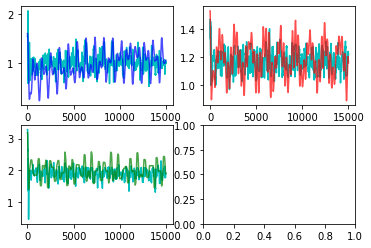

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

if t_or_r:
    trj = traj.cpu().numpy()

    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(trj[0, :, 0], c='c')
    axs[0, 0].plot(y[traj_id, :, 0], c='b', alpha=0.7)
    axs[0, 1].plot(trj[0, :, 1], c='c')
    axs[0, 1].plot(y[traj_id, :, 1], c='r', alpha=0.7)
    axs[1, 0].plot(trj[0, :, 2], c='c')
    axs[1, 0].plot(y[traj_id, :, 2], c='g', alpha=0.7)
else:
    colors = ["b", "r", "g", "y"]

    latent_values = r.squeeze(1).cpu().numpy()
    kmeans = KMeans(n_clusters=4, random_state=0)
    labels = kmeans.fit_predict(latent_values)

    print(np.mean(labels), labels, sep='\n')
    pca = PCA(n_components=2)
    reduced_latent = pca.fit_transform(latent_values)

    label_colors = []
    for i in labels:
        label_colors.append(colors[i])
    plt.scatter(reduced_latent[:, 0], reduced_latent[:, 1], c=label_colors, s=30)